In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!pip install pygame
!pip install pyvirtualdisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.7 MB/s eta 0:00:00


In [3]:
import math
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from IPython.display import clear_output
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay, display
from PIL import Image
import pickle
import matplotlib.pyplot as plt

In [4]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [5]:
ENV_NAME = "Acrobot-v1"
ENV = gym.make(ENV_NAME)
num_inputs  = ENV.observation_space.shape[0]
num_outputs = ENV.action_space.n
MAX_EPISODES = 200
N_STEPS = [None, 1, 4, 8]
ALPHA = 7e-4
HIDDEN_SIZE1 = 32
HIDDEN_SIZE2 = 32
GAMMA = 0.99
NUM_RUNS = 10
# SEED = [42,43,44,45,46,47,48,49,50,51]

class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size1, hidden_size2):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_outputs),
            nn.Softmax(dim=-1),
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist  = Categorical(probs)
        return dist, value

In [6]:
def compute_full_returns(rewards, gamma=0.99):
    R = 0
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R 
        returns.insert(0, R)
    return returns

In [7]:
avg = []
var = []
std = []
avg_steps = []

for N_STEP in N_STEPS:
    n_step = N_STEP
    gamma = GAMMA
    reward_runs = []
    steps_run = []

    print(f'------------------------------------------------------------------------------------------------------------------------------')
    print(f'Environment={ENV_NAME}\nn_step={n_step}, alpha={ALPHA}, gamma={GAMMA}, number of hidden layers=2, size of hidden layer=[{HIDDEN_SIZE1},{HIDDEN_SIZE2}], max episodes={MAX_EPISODES}, num runs={NUM_RUNS}')
    print(f'------------------------------------------------------------------------------------------------------------------------------')
    print('\n')

    for run in range(NUM_RUNS):
        reward_per_episode = []
        steps_per_episode = []
        print(f'------------------------------------------------------------------------------------------------------------------------------')
        print(f'Run {run+1}')
        print(f'------------------------------------------------------------------------------------------------------------------------------')
        print('\n')
        model = ActorCritic(num_inputs, num_outputs, HIDDEN_SIZE1, HIDDEN_SIZE2).to(device)
        optimizer = optim.Adam(lr=ALPHA, params=model.parameters())
        for ep in range(MAX_EPISODES):
            state = ENV.reset(seed=42)
            state = torch.FloatTensor(state).to(device)

            log_probs = []
            values    = []

            state_buffer = [state]
            action_buffer = []

            rewards   = []
            masks     = []
            ep_reward = 0

            done = False

            num_steps = 0

            while not done:
                num_steps += 1
                dist, value = model(state) # dist is the an array of Categorical(Q(s,a')) where a' is varied and value is V(s)
                action = dist.sample() # sample action from the categorical distribution of Q(s,a')
                next_state, reward, done, _ = ENV.step(action.cpu().numpy())
                next_state = torch.FloatTensor(next_state).to(device)
                state_buffer.append(next_state)
                ep_reward += reward

                log_prob = dist.log_prob(action)
                log_probs.append(log_prob.reshape(-1))
                action_buffer.append(action)
                values.append(value.reshape(-1))

                rewards.append(torch.FloatTensor([reward]).unsqueeze(1).to(device))
                masks.append(torch.FloatTensor([1 - done]).unsqueeze(1).to(device))

                if n_step is not None and len(rewards) >= n_step:
                    # compute n_step return
                    ret = 0 
                    for i in range(n_step):
                        ret = gamma*ret + rewards[-i - 1]
                    # state w.r.t which we are updating
                    s_1 = state_buffer.pop(0)
                    dist, v_s_1 = model(s_1) # categorical distribution of the state action value pairs and the value of the state
                    # action that we took in that state
                    a = action_buffer.pop(0)
                    # s_n+t
                    s_n = state_buffer[-1]
                    _, v_s_n = model(s_n)
                    # computing advantage
                    advantage = ret + gamma**n_step * v_s_n * masks[-1] - v_s_1
                    # actor loss and critic loss
                    actor_loss  = -(dist.log_prob(a) * advantage.detach()) # -logprob_pi_(a_t|s_t) * delta_t
                    critic_loss = advantage.pow(2) # delta_t ** 2

                    loss = actor_loss + critic_loss
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                state = next_state

            reward_per_episode.append(ep_reward)
            steps_per_episode.append(num_steps)

            avg_rew = np.mean(reward_per_episode[-10:])
            print(f'\tEpisode {ep+1} Number of steps = {num_steps} Average reward for past 10 episodes {avg_rew}')
            
            temp_n = len(state_buffer)-1
#             print(temp_n)
#             print(len(rewards))
#             if n_step is not None:
                # compute n_step return
            ret_ = compute_full_returns(rewards[-temp_n:], gamma)
#             print(ret_)
#             print(len(ret_))
#             print(temp_n-1)
            for i in range(temp_n):
                # compute return
                ret = ret_[i]
                # state w.r.t which we are updating
                s_1 = state_buffer.pop(0)
                # categorical distribution of the state action value pairs and the value of the state
                dist, v_s_1 = model(s_1)
                # action that we took in that state
                a = action_buffer.pop(0)
                # compute advantage
                advantage = ret - v_s_1 # done=1 in this case and hence v_s_n=0
                actor_loss  = -(dist.log_prob(a) * advantage.detach()) # -logprob_pi_(a_t|s_t) * delta_t
                critic_loss = advantage.pow(2) # delta_t ** 2
                loss = actor_loss + critic_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


#             elif n_step is None:
#                 log_probs = torch.cat(log_probs)
#                 values    = torch.cat(values)
#                 returns = compute_full_returns(rewards, gamma)
#                 returns  = torch.cat(returns).detach()
#                 advantage = returns - values # as given in the assignment
#                 actor_loss  = -(log_probs * advantage.detach()).sum()
#                 critic_loss = advantage.pow(2).sum()
#                 loss = actor_loss + critic_loss
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
        reward_runs.append(reward_per_episode)
        steps_run.append(steps_per_episode)
    r_file = f'reward_runs_{ENV_NAME}_network1_alpha={ALPHA}_max_episodes={MAX_EPISODES}_nstep={N_STEP}.pkl'
    with open(r_file, 'wb') as f:
        pickle.dump(reward_runs, f)
    f.close()

    s_file = f'steps_run_{ENV_NAME}_network1_alpha={ALPHA}_max_episodes={MAX_EPISODES}_nstep={N_STEP}.pkl'
    with open(s_file, 'wb') as f:
        pickle.dump(steps_run, f)
    f.close()
    
    avg_steps.append(np.average(steps_run, axis=0))
    avg_r = np.average(reward_runs, axis=0)
    avg.append(avg_r)
    var_r = np.var(reward_runs, axis=0)
    var.append(var_r)
    std.append(np.sqrt(var_r))

    plt.plot(np.arange(1, len(avg_r) + 1), avg_r)
    n = f'{N_STEP}-step Actor Critic' if N_STEP is not None else 'Full Return Actor Critic'
    plt.suptitle(f'Average Rewards (over 10 runs) vs Episodes for {n}')
    plt.title(f'Environment={ENV_NAME}, alpha={ALPHA}, max episodes={MAX_EPISODES}')
    plt.xlabel(f'Episodes')
    plt.ylabel(f'Rewards')
    plt.savefig(f'avg_rewards_{n}_{ENV_NAME}_lr{ALPHA}_eps{MAX_EPISODES}.png')
    plt.close()

    plt.plot(np.arange(1, len(var_r) + 1), (var_r))
    n = f'{N_STEP}-step Actor Critic' if N_STEP is not None else 'Full Return Actor Critic'
    plt.suptitle(f'Variance of Rewards (over 10 runs) vs Episodes for {n}')
    plt.title(f'Environment={ENV_NAME}, alpha={ALPHA}, max episodes={MAX_EPISODES}')
    plt.xlabel(f'Episodes')
    plt.ylabel(f'Variance of Rewards')
    plt.savefig(f'var_rewards_{n}_{ENV_NAME}_lr{ALPHA}_eps{MAX_EPISODES}.png')
    plt.close()

    plt.plot(np.arange(1, len(var_r) + 1), np.sqrt(var_r))
    n = f'{N_STEP}-step Actor Critic' if N_STEP is not None else 'Full Return Actor Critic'
    plt.suptitle(f'Std Dev of Rewards (over 10 runs) vs Episodes for {n}')
    plt.title(f'Environment={ENV_NAME}, alpha={ALPHA}, max episodes={MAX_EPISODES}')
    plt.xlabel(f'Episodes')
    plt.ylabel(f'Variance of Rewards')
    plt.savefig(f'std_rewards_{n}_{ENV_NAME}_lr{ALPHA}_eps{MAX_EPISODES}.png')
    plt.close()

------------------------------------------------------------------------------------------------------------------------------
Environment=Acrobot-v1
n_step=None, alpha=0.0007, gamma=0.99, number of hidden layers=2, size of hidden layer=[32,32], max episodes=200, num runs=10
------------------------------------------------------------------------------------------------------------------------------


------------------------------------------------------------------------------------------------------------------------------
Run 1
------------------------------------------------------------------------------------------------------------------------------


	Episode 1 Number of steps = 500 Average reward for past 10 episodes -500.0
	Episode 2 Number of steps = 221 Average reward for past 10 episodes -360.0
	Episode 3 Number of steps = 249 Average reward for past 10 episodes -322.6666666666667
	Episode 4 Number of steps = 139 Average reward for past 10 episodes -276.5
	Episode 5 Number

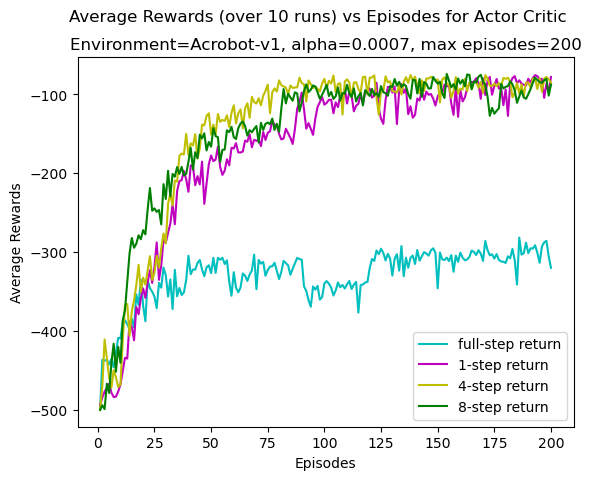

In [8]:
c = ['c', 'm', 'y', 'g']
label = ['full-step return', '1-step return', '4-step return', '8-step return']
for i,a in enumerate(avg):
    plt.plot(np.arange(1, len(a) + 1), a, c=c[i], label=label[i])
plt.suptitle(f'Average Rewards (over 10 runs) vs Episodes for Actor Critic')
plt.title(f'Environment={ENV_NAME}, alpha={ALPHA}, max episodes={MAX_EPISODES}')
plt.xlabel(f'Episodes')
plt.ylabel(f'Average Rewards')
plt.legend()
plt.savefig(f'avg reward comparison.png')

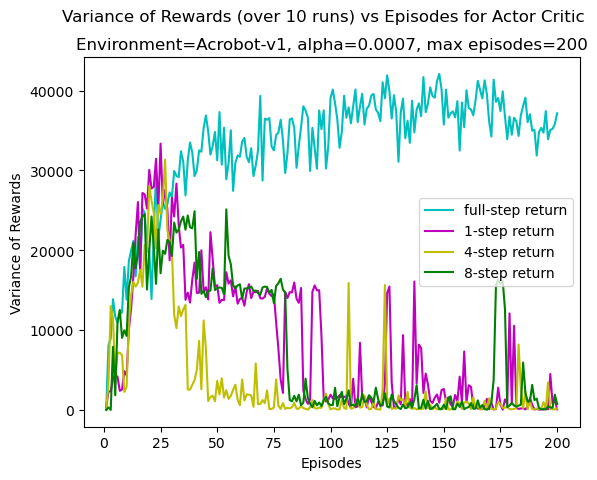

In [9]:
c = ['c', 'm', 'y', 'g']
label = ['full-step return', '1-step return', '4-step return', '8-step return']
for i,a in enumerate(var):
    plt.plot(np.arange(1, len(a) + 1), a, c=c[i], label=label[i])
plt.suptitle(f'Variance of Rewards (over 10 runs) vs Episodes for Actor Critic')
plt.title(f'Environment={ENV_NAME}, alpha={ALPHA}, max episodes={MAX_EPISODES}')
plt.xlabel(f'Episodes')
plt.ylabel(f'Variance of Rewards')
plt.legend()
plt.savefig(f'var reward comparison.png')

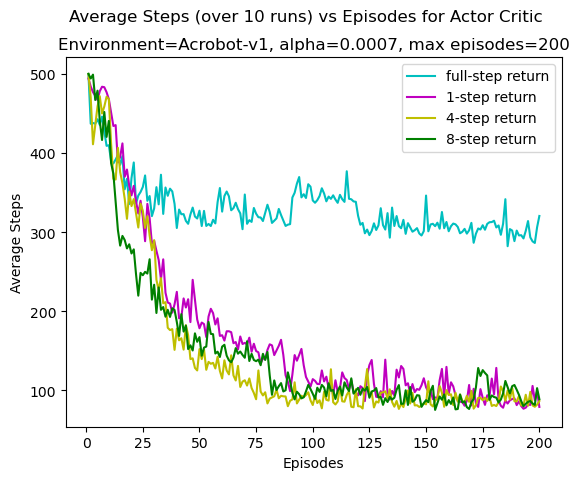

In [10]:
c = ['c', 'm', 'y', 'g']
label = ['full-step return', '1-step return', '4-step return', '8-step return']
for i,a in enumerate(avg_steps):
    plt.plot(np.arange(1, len(a) + 1), a, c=c[i], label=label[i])
plt.suptitle(f'Average Steps (over 10 runs) vs Episodes for Actor Critic')
plt.title(f'Environment={ENV_NAME}, alpha={ALPHA}, max episodes={MAX_EPISODES}')
plt.xlabel(f'Episodes')
plt.ylabel(f'Average Steps')
plt.legend()
plt.savefig(f'avg steps comparison.png')